In [2]:
import pandas as pd
import numpy as np
import nltk 
from collections import Counter
from nltk.tokenize import word_tokenize
import seaborn as sns
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import wordcloud


In [3]:
df=pd.read_csv ('clean.csv')
df.tail(12)

,Unnamed: 0,label,judul,Unnamed: 0.1,stop
4506,387,0,klarifikasi terkait perbedaan hasil situng kpu...,387.0,klarifikasi kait beda hasil situng kpu pindah ...
4507,388,0,pks gerindra purwakarta bantah pasang spanduk ...,388.0,pks gerindra purwakarta bantah pasang spanduk ...
4508,389,0,universitas muhammadiyah kupang bantah mengini...,389.0,universitas muhammadiyah kupang bantah mengini...
4509,390,0,klarifikasi isu ott bupati kapuas kpk,390.0,klarifikasi isu ott bupati kapuas kpk
4510,391,0,kronologis polisi berondong sedan terobos razi...,391.0,kronologis polisi berondong sedan terobos razi...
4511,392,0,dituding tawarkan pekerjaan peretas situs kpu ...,392.0,tuding tawar kerja retas situs kpu polri bantah
4512,393,0,terduga teroris is tertangkap sleman yogyakart...,393.0,duga teroris is tangkap sleman yogyakarta lati...
4513,394,0,klarifikasi polres bogor terkait pembuatan sim...,394.0,klarifikasi polres bogor kait buat sim tes rp ...
4514,395,0,ketua inasgoc bantah indonesia bermain curang ...,395.0,ketua inasgoc bantah indonesia main curang cab...
4515,396,0,klarifikasi sholat ibadah agama darurat,396.0,klarifikasi sholat ibadah agama darurat


In [4]:
df.dtypes

Unnamed: 0        int64
label             int64
judul            object
Unnamed: 0.1    float64
stop             object
dtype: object

In [4]:
df_pos = df[df['label']==0]['stop']
df_pos.to_csv('nonhoax.csv', encoding='utf8', index = False)
df_neg = df[df['label']==1]['stop']
df_neg.to_csv('hoax.csv', encoding='utf8', index = False)

C:\Users\tamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
C:\Users\tamu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


Proporsi label


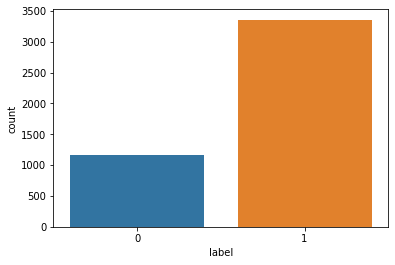

In [5]:
print("Proporsi label")
ax = sns.countplot(df['label'])

In [6]:
df['label'].value_counts()

1    3356
0    1162
Name: label, dtype: int64

In [7]:
# Bentuk VSM-nya
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(lowercase=True, smooth_idf= True, sublinear_tf=True, 
                                   ngram_range=(1, 2), max_df=0.90, min_df=2)

In [8]:
##TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
#vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer = TfidfVectorizer(max_df=0.1, min_df=5, ngram_range=(1, 2))

listdata=df['stop'].values.astype('object')
listdata = [d for d in listdata]

listdata
v = TfidfVectorizer(decode_error='replace', encoding='utf-8')
tfidf = v.fit_transform(df['stop'].values.astype('U'))
y = df.iloc[:, 2].values
print(tfidf.shape, len(y)) 

(4518, 6836) 4518


In [9]:
#balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

oversampling_tf = SMOTE(sampling_strategy='all')

oversampling_tf.fit(tfidf,df['label'])

SMOTE(sampling_strategy='all')

In [11]:
fitur_tf, label_tf = oversampling_tf.fit_resample(tfidf,df['label'])
print(fitur_tf.shape)
print(label_tf.shape)

(6712, 6836)
(6712,)


In [12]:
from sklearn.model_selection import train_test_split
seed = 1
X = df['stop'].values.astype('U')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train = vectorizer.fit_transform(X_train) # "Fit_Transform"
X_test = vectorizer.transform(X_test) # Perhatikan disini hanya "Transform"

print(X_train.shape, X_test.shape)

(3162, 1102) (1356, 1102)


In [13]:
def hapusKosong(X,y):
    y = y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)
print(X_train.shape, X_test.shape)

(3111, 1102) (1331, 1102)


In [ ]:
fig = plt.subplots(figsize=(15, 5))

#plot pdf feat 1
plt.subplot(1, 2, 1)
sns.kdeplot(train_df[feat1][train_df['target'] == 0], shade=True, color="b", label = 'target = 0')
sns.kdeplot(train_df[feat1][train_df['target'] == 1], shade=True, color="r", label = 'target = 1')
plt.title(feat1)
plt.xlabel('Feature Values')
plt.ylabel('Probability')

In [14]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dSVM = svm.SVC( kernel = 'linear')
dSVM.fit(X_train, y_train)
y_SVM = dSVM.predict(X_test)
print('Akurasi = ', accuracy_score(y_test, y_SVM))
print(confusion_matrix(y_test, y_SVM))
print(classification_report(y_test, y_SVM))

Akurasi =  0.821938392186326
[[153 205]
 [ 32 941]]
              precision    recall  f1-score   support

           0       0.83      0.43      0.56       358
           1       0.82      0.97      0.89       973

    accuracy                           0.82      1331
   macro avg       0.82      0.70      0.73      1331
weighted avg       0.82      0.82      0.80      1331



In [27]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
kf = KFold(n_splits=4)
mae_train = []
mae_test = []
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = KNeighborsClassifier(n_neighbors=2)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [15]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report


model = neighbors.KNeighborsClassifier()
kNN = model.fit(X_train, y_train)
y_kNN = kNN.predict(X_test)

print('Akurasi = ', accuracy_score(y_test, y_kNN))
print(confusion_matrix(y_test, y_kNN))
print(classification_report(y_test, y_kNN))

Akurasi =  0.7625845229151015
[[107 251]
 [ 65 908]]
              precision    recall  f1-score   support

           0       0.62      0.30      0.40       358
           1       0.78      0.93      0.85       973

    accuracy                           0.76      1331
   macro avg       0.70      0.62      0.63      1331
weighted avg       0.74      0.76      0.73      1331



In [16]:
from sklearn.naive_bayes import GaussianNB
naivbayes = GaussianNB()
naivbayes.fit(X_train.toarray(), y_train)
y_NB = naivbayes.predict(X_test.toarray())
print(confusion_matrix(y_test, y_NB))
print(accuracy_score(y_test, y_NB))
print(classification_report(y_test, y_NB))

[[316  42]
 [634 339]]
0.49211119459053343
              precision    recall  f1-score   support

           0       0.33      0.88      0.48       358
           1       0.89      0.35      0.50       973

    accuracy                           0.49      1331
   macro avg       0.61      0.62      0.49      1331
weighted avg       0.74      0.49      0.50      1331



In [17]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression(solver="lbfgs", multi_class="auto")
model_logreg.fit(X_train, y_train)
Y_pred = model_logreg.predict(X_test)
print("Accuracy:", accuracy_score(Y_pred, y_test))
print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

Accuracy: 0.8196844477836214
[[136 222]
 [ 18 955]]
              precision    recall  f1-score   support

           0       0.88      0.38      0.53       358
           1       0.81      0.98      0.89       973

    accuracy                           0.82      1331
   macro avg       0.85      0.68      0.71      1331
weighted avg       0.83      0.82      0.79      1331



In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_rf))
print(confusion_matrix(y_test, y_rf))
print(classification_report(y_test, y_rf))

Accuracy: 0.8407212622088656
[[198 160]
 [ 52 921]]
              precision    recall  f1-score   support

           0       0.79      0.55      0.65       358
           1       0.85      0.95      0.90       973

    accuracy                           0.84      1331
   macro avg       0.82      0.75      0.77      1331
weighted avg       0.84      0.84      0.83      1331



In [19]:
!pip install graphviz dtreeviz
from sklearn.model_selection import cross_val_score
import graphviz, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns
from pandas.plotting import scatter_matrix 
from sklearn import model_selection, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from dtreeviz.trees import *
from IPython.core.display import display, HTML
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import svm, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import VotingClassifier
from collections import Counter
sns.set(style="ticks", color_codes=True)

In [19]:
#model_ = ['kNN', 'SVM', "Rf"]
model_ = ['SVM', "Rf"]
#knn_score = cross_val_score(kNN_, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-2, verbose=1)
svm_score = cross_val_score(svm_, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-2, verbose=1)
Rf_score= cross_val_score(Rf_, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-2, verbose=1)
#score_ = [knn_score, svm_score, Rf_score]
score_ = [ svm_score, Rf_score]
data = {m:s for m,s in zip(model_, score_)}
for name in data.keys():
print("Accuracy %s: %0.2f (+/- %0.2f)" % (name, data[name].mean(), data[name].std() * 2))
sns.boxplot(data=pd.DataFrame(data), orient='h')
plt.savefig("plot.png")


IndentationError: expected an indented block (<ipython-input-19-2b289f72b0a4>, line 10)

Regresi Logistik [0.8194444444444444]
Random Forest [0.8229166666666666]
SVM [0.8194444444444444]


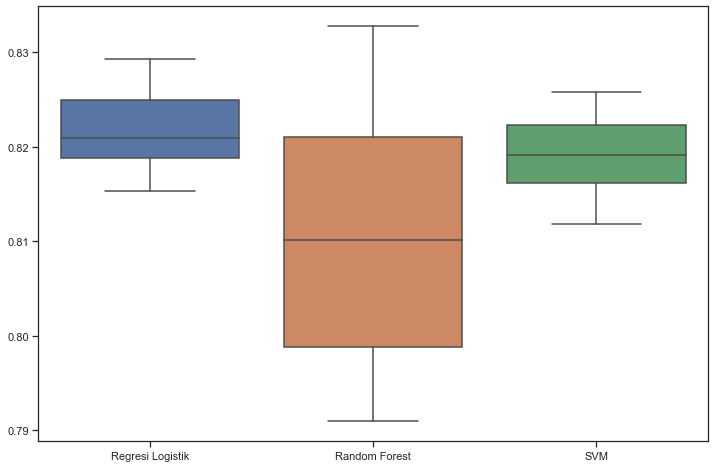

In [50]:
clf = LogisticRegression(solver='liblinear')
rf = RandomForestClassifier()
svm_ = svm.SVC()
Models = [('Regresi Logistik', clf), ('Random Forest', rf), ('SVM', svm_)]
Scores = {}
for model_name, model in Models:
    Scores[model_name] = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')

dt = pd.DataFrame.from_dict(Scores)
plt.figure(figsize=(12,8))
ax = sns.boxplot(data=dt)
for m, s in Scores.items():
    print(m,list(s)[:1])

# cross validasi

In [20]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("best parameters",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-tes

best parameters {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.8190277434248495


C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\tamu\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.74445544        nan 0.74445544        nan 0.75377298
        nan 0.81902774        nan 0.8003875         nan 0.76469927
        nan 0.74701439]
  category=UserWarning


In [21]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline 

In [22]:
parameters = [ {"n_estimators":[10,20,30,40], "max_depth":[4, 5, 10, 20, 100, 300, 500],"random_state":[0]}]
Rf = GridSearchCV(RandomForestClassifier(), parameters, cv=10, scoring = "accuracy")
Rf.fit(X_train, y_train)
print(Rf.best_estimator_)
print(Rf.best_score_)

RandomForestClassifier(max_depth=500, n_estimators=40, random_state=0)
0.8411987797839886


In [53]:
#grid search
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [10,20,30,40],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,20,100,200,300],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_
print("best parameters ",CV_rfc.best_params_)
print("accuracy :",CV_rfc.best_score_)

best parameters  {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 30}
accuracy : 0.820967126193001


In [54]:
from sklearn.model_selection import GridSearchCV 
pipeSVM = make_pipeline(svm.SVC())
kCV = 10
# defining parameter range 
param_grid = {'C': [0.1,1, 5, 10],
              'kernel': ['linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(X_train, y_train)

# print best parameter after tuning 
print("best parameters:",grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 

print("accuracy:",grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.814 total time=   0.5s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.814 total time=   0.5s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.815 total time=   0.5s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.815 total time=   0.5s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.815 total time=   0.6s
[CV 1/5] END ................C=1, kernel=linear;, score=0.819 total time=   0.7s
[CV 2/5] END ................C=1, kernel=linear;, score=0.819 total time=   0.5s
[CV 3/5] END ................C=1, kernel=linear;, score=0.821 total time=   0.5s
[CV 4/5] END ................C=1, kernel=linear;, score=0.815 total time=   0.5s
[CV 5/5] END ................C=1, kernel=linear;, score=0.821 total time=   0.5s
[CV 1/5] END ................C=5, kernel=linear;, score=0.763 total time=   0.6s
[CV 2/5] END ................C=5, kernel=linear;,

# evaluasi model

In [60]:
svm_.fit(X_train, y_train)
y_pred = svm_.predict(X_test)
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[ 17 218]
 [  4 993]]
              precision    recall  f1-score   support

           0       0.81      0.07      0.13       235
           1       0.82      1.00      0.90       997

    accuracy                           0.82      1232
   macro avg       0.81      0.53      0.52      1232
weighted avg       0.82      0.82      0.75      1232

Akurasi :  0.8198051948051948


In [61]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
63
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[ 19 216]
 [  9 988]]
              precision    recall  f1-score   support

           0       0.68      0.08      0.14       235
           1       0.82      0.99      0.90       997

    accuracy                           0.82      1232
   macro avg       0.75      0.54      0.52      1232
weighted avg       0.79      0.82      0.75      1232

Akurasi :  0.8173701298701299


## confusion matrix


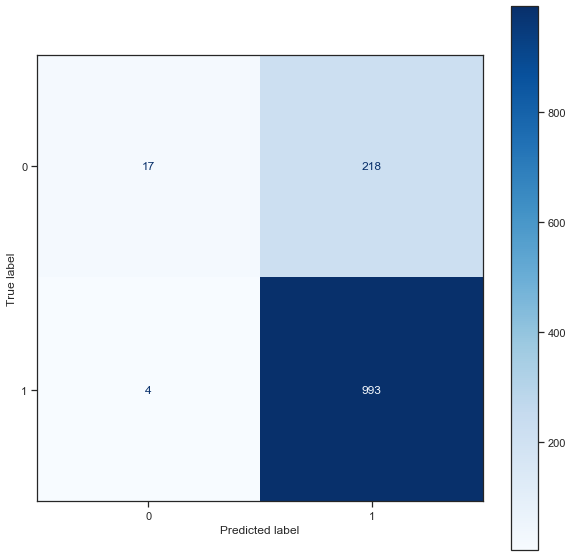

In [62]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.savefig('confusion matrix.png')
plt.show()

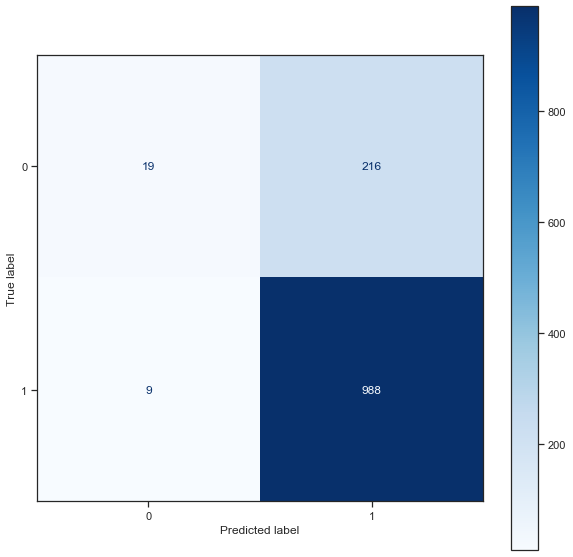

In [63]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.savefig('confusion matrix.png')
plt.show()